In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial.distance import cdist
import yaml
import sys
import os
# Dynamically determine the project root directory
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))
from src.data_loading.simple_loader import load_processed_berkeley_earth, load_processed_era5, load_config, load_processed_elevation_data, load_processed_station_density_data

# load processed data
# load station density data
# process station density data 
# create exploratory plots of features to difference for western united states


In [2]:
class TemperatureDatasetMetrics:
    
    def __init__(self, variable='tavg'):
        """
        Initialize with a specific temperature variable.

        Variables: 'tavg', 'tmin', 'tmax'
        """
        self.variable = variable
        self.be_data = load_processed_berkeley_earth(variable)
        self.be_data['abs_temp'] = self.be_data.temperature.groupby('time.month')+self.be_data.climatology.rename({'month_number': 'month'})

        self.era5_data = load_processed_era5(variable)
        self.era5_data['abs_temp'] = self.era5_data.temperature.groupby('time.month') + self.era5_data.climatology - 273.15
        
        self.difference= self.be_data.temperature - self.era5_data.temperature
        self.abs_difference = self.be_data.abs_temp - self.era5_data.abs_temp
        
        self.config = load_config()
        
    def slice_data(self, time_slice=('1940-01-01', '2025-01-01'), lat_slice=(-90, 90), lon_slice=(-180, 180), land_only_flag=False):
        """Slice the data based on time, latitude, and longitude."""
        
        if land_only_flag:
            self.be_slice = self.be_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.era5_slice = self.era5_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.difference_slice = self.difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.abs_difference_slice = self.abs_difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
        else:
            self.be_slice = self.be_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.era5_slice = self.era5_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.difference_slice = self.difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.abs_difference_slice = self.abs_difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
    
    def CDF(data):
        # flattend dimensions
        data = data.values.flatten() 
        # Remove NaN values
        data = data[~np.isnan(data)]
        x_values = np.sort(data)
        # Calculate CDF values
        cdf_values = np.searchsorted(np.sort(data), x_values, side='right') / len(data)
        return x_values, cdf_values
    
    
    def calculate_basic_statistics(self, time_slice=('1940-01-01', '2025-01-01')):
        """Calculate basic statistical metrics."""
        be_temp = self.be_data.sel(time=slice(*time_slice)).temperature
        era5_temp = self.era5_data.sel(time=slice(*time_slice)).temperature
        
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)
        
        metrics = {
            'mean_difference': float((era5_valid - be_valid).mean().values),
            'std_difference': float((era5_valid - be_valid).std().values),
            'rmse': float(np.sqrt(((era5_valid - be_valid) ** 2).mean()).values),
            'mae': float(np.abs(era5_valid - be_valid).mean().values),
            'be_mean': float(be_valid.mean().values),
            'era5_mean': float(era5_valid.mean().values),
            'be_std': float(be_valid.std().values),
            'era5_std': float(era5_valid.std().values),
        }
        
        #Calculate correlation coefficient
        be_flat = be_valid.values.flatten()
        era5_flat = era5_valid.values.flatten()
        valid_indices = ~(np.isnan(be_flat) | np.isnan(era5_flat))
        
        if np.sum(valid_indices) > 0:
           correlation, p_value = stats.pearsonr(be_flat[valid_indices], era5_flat[valid_indices])
           metrics['correlation'] = float(correlation)
           metrics['correlation_pvalue'] = float(p_value)
        else:
           metrics['correlation'] = np.nan
           metrics['correlation_pvalue'] = np.nan
            
        return metrics
    
    def calculate_time_series(self, lat_slice=(-90, 90), land_only_flag=False):
        """Calculate spatially averaged metrics for given latitude band.
        Metrics include: mean difference, std_difference, rmse, and mae."""
        # slice latitude range
        be_temp = self.be_data.sel(latitude=slice(*lat_slice)).temperature
        era5_temp = self.era5_data.sel(latitude=slice(*lat_slice)).temperature
        
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)

        # If land_only_flag is True, apply land mask
        if land_only_flag:
            be_valid = be_valid.where(self.be_data.land_mask)
        
        # calculate spatially averaged mean difference
        difference = era5_valid - be_valid
        output = {}
        output['mean_difference'] = difference.mean(dim=['latitude', 'longitude'])
        output['std_difference'] = difference.std(dim=['latitude', 'longitude'])
        output['rmse'] = np.sqrt((difference ** 2).mean(dim=['latitude', 'longitude']))
        output['mae'] = np.abs(difference).mean(dim=['latitude', 'longitude'])
        return output

    def calculate_temporally_averaged_metrics(self, time_slice=('1940-01-01', '2025-01-01')):
        """Calculate temporally averaged metrics for the specified time slice."""
        # slice time range
        be_temp = self.be_data.sel(time=slice(*time_slice)).temperature
        era5_temp = self.era5_data.sel(time=slice(*time_slice)).temperature
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)
        difference = era5_valid - be_valid
        
        output = {}
        output['mean_difference'] = difference.mean(dim=['time'])
        output['std_difference'] = difference.std(dim=['time'])
        output['rmse'] = np.sqrt((difference ** 2).mean(dim=['time']))
        output['mae'] = np.abs(difference).mean(dim=['time'])
        return output

In [3]:
# load temperature data and calculate difference, load elevation data, load station density data
TAVG = TemperatureDatasetMetrics(variable='tavg')
elevation_data = load_processed_elevation_data()
station_density_data = load_processed_station_density_data()
wus_elevation = elevation_data.sel(latitude=slice(20, 60), longitude=slice(-140, -100)).where(TAVG.be_data.land_mask == 1)
wus_station_density = station_density_data.station_counts.sel(time=slice('2024-01-01','2024-12-31'),latitude=slice(20, 60), longitude=slice(-140, -100))
wus_station_mean = wus_station_density.mean(dim='time')

time_slice = ('2024-01-01', '2024-12-31')
lat_slice = (20, 60)
lon_slice = (-140, -100)
TAVG.slice_data(time_slice=time_slice, lat_slice=lat_slice, lon_slice=lon_slice, land_only_flag=True)

Text(0, 0.5, 'Latitude')

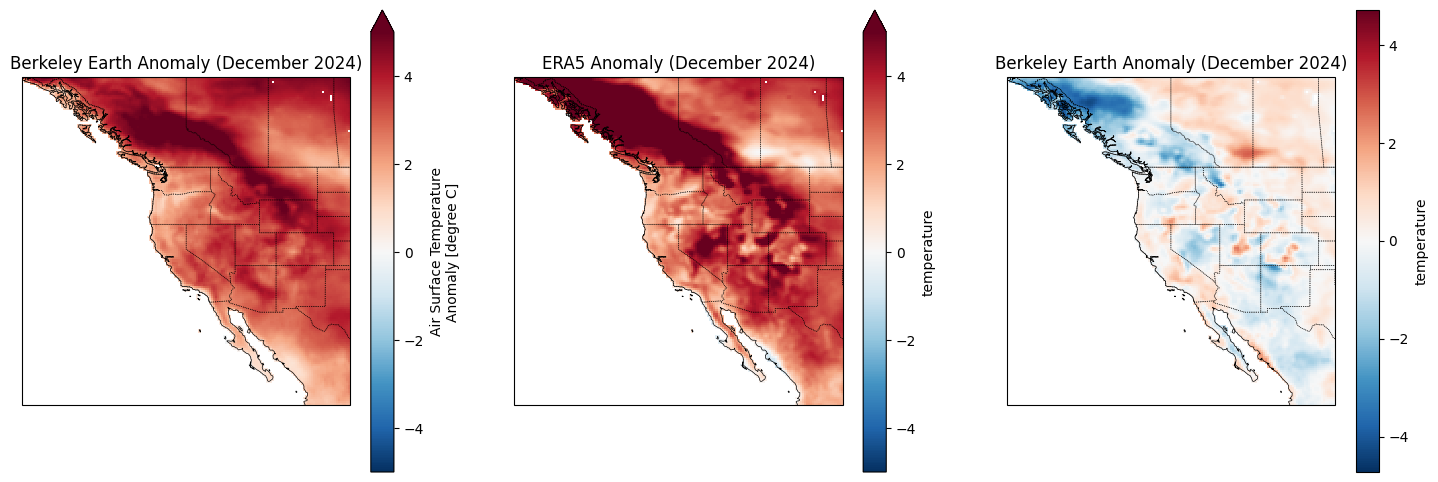

In [14]:
# create 2 plot of single months from Berkeley Earth and ERA5
plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
TAVG.be_slice.temperature[-1].plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('Berkeley Earth Anomaly (December 2024)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

ax1 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
TAVG.era5_slice.temperature[-1].plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('ERA5 Anomaly (December 2024)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

ax1 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
TAVG.difference_slice[-1].plot(ax=ax1, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('Berkeley Earth Anomaly (December 2024)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

/home/devin/miniconda3/envs/temp-comparison/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0, 'Longitude')

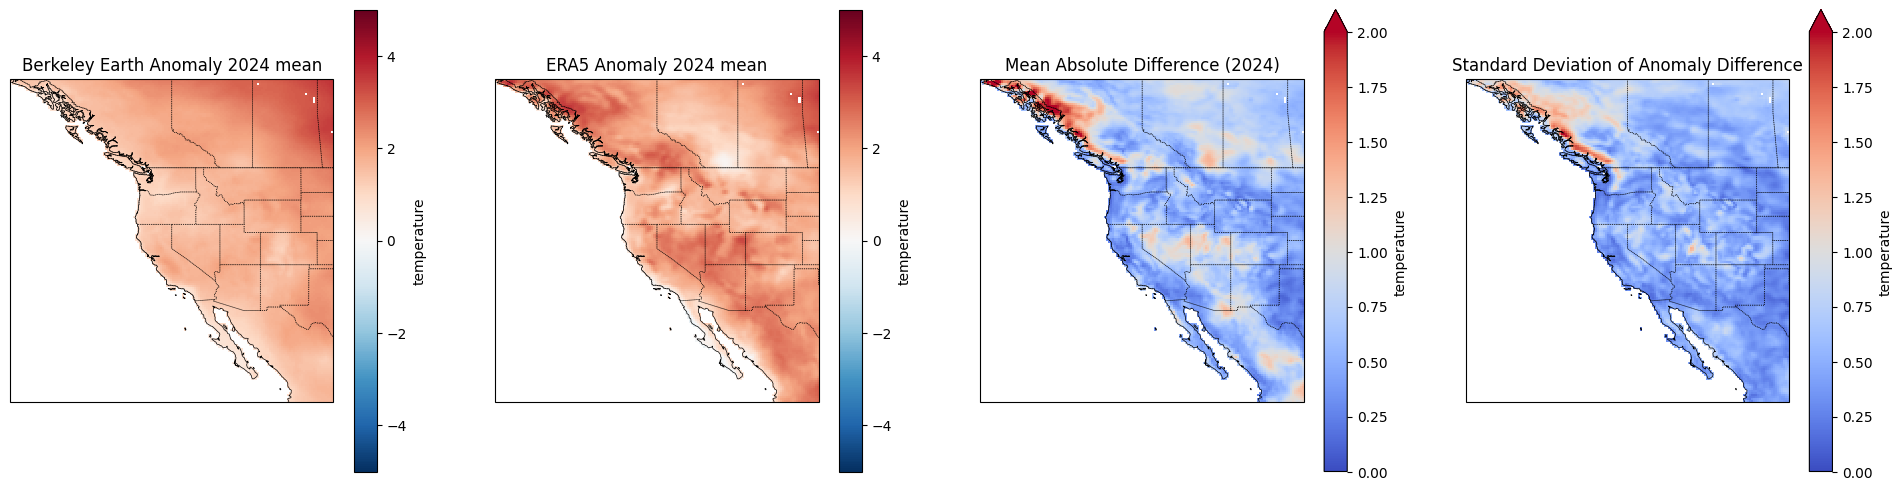

In [16]:
# create 2 plot of annual average from Berkeley Earth and ERA5
be_mean = TAVG.be_slice.temperature.mean(dim='time')
era5_mean = TAVG.era5_slice.temperature.mean(dim='time')

plt.figure(figsize=(24, 6))
ax1 = plt.subplot(1, 4, 1, projection=ccrs.PlateCarree())
be_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('Berkeley Earth Anomaly 2024 mean')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

ax1 = plt.subplot(1, 4, 2, projection=ccrs.PlateCarree())
era5_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('ERA5 Anomaly 2024 mean')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

# Mean 2024 Anomaly Plot: mean difference and 1 with std of difference for 2024
diff_mean = np.abs(TAVG.difference_slice).mean(dim='time')
diff_std = TAVG.difference_slice.std(dim='time')
# Mean Absolute Difference Plot
ax1 = plt.subplot(1, 4, 3, projection=ccrs.PlateCarree())
diff_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-0, vmax=2)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax1.set_title('Mean Absolute Difference (2024)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

# Standard Deviation of Absolute Difference Plot
ax2 = plt.subplot(1, 4, 4, projection=ccrs.PlateCarree())
diff_std.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=0, vmax=2)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
# add country and state lines
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax2.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax2.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
ax2.set_title('Standard Deviation of Anomaly Difference')
ax2.set_xlabel('Longitude')



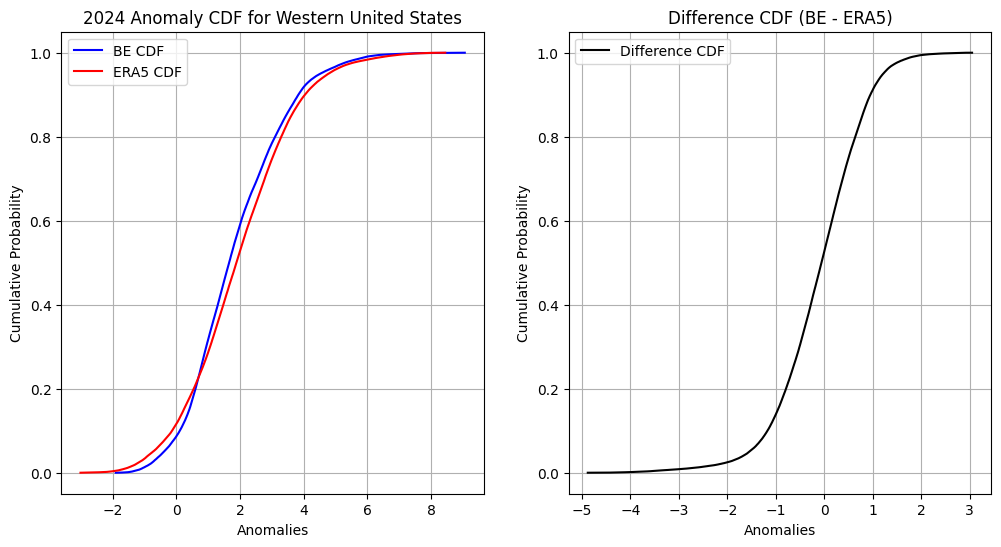

In [ ]:
be_x,be_cdf = TemperatureDatasetMetrics.CDF(TAVG.be_slice.temperature)
era5_x, era5_cdf = TemperatureDatasetMetrics.CDF(TAVG.era5_slice.temperature)
diff_x, diff_cdf = TemperatureDatasetMetrics.CDF(TAVG.difference_slice)

# create 2-figure plot showing the CDFS of BE and ERA5 and the difference
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(be_x, be_cdf, linestyle='-', color='blue', label='BE CDF')
plt.plot(era5_x, era5_cdf, linestyle='-', color='red', label='ERA5 CDF')
plt.xlabel('Anomalies')
plt.ylabel('Cumulative Probability')
plt.title('2024 Anomaly CDF for Western United States')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(diff_x, diff_cdf, linestyle='-', color='black', label='Difference CDF')
plt.xlabel('Anomalies')
plt.ylabel('Cumulative Probability')
plt.title('Difference CDF (BE - ERA5)')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Mean 2024 Difference vs Mean 2024 Station Density')

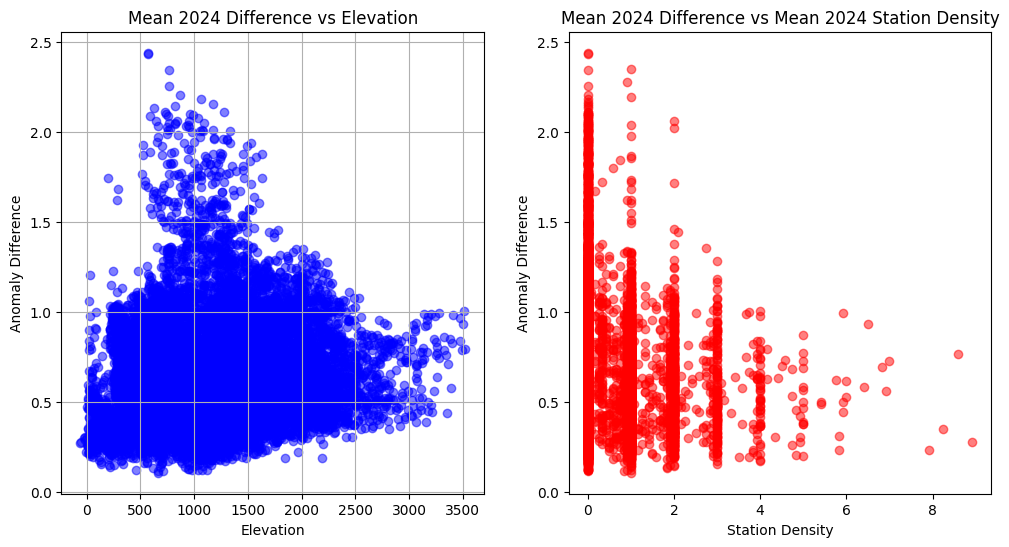

In [14]:
# create scatter plots of wus_difference vs. wus_elevation and wus_station_density vs. wus_difference

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(wus_elevation.elevation, diff_mean, c='blue', alpha=0.5)
plt.xlabel('Elevation')
plt.ylabel('Anomaly Difference')
plt.title('Mean 2024 Difference vs Elevation')
plt.grid() 
plt.subplot(1, 2, 2)
plt.scatter(wus_station_mean, diff_mean, c='red', alpha=0.5)
plt.xlabel('Station Density')
plt.ylabel('Anomaly Difference')
plt.title('Mean 2024 Difference vs Mean 2024 Station Density')

Text(0.5, 1.0, 'std of 2024 difference vs 2024 mean Station Density')

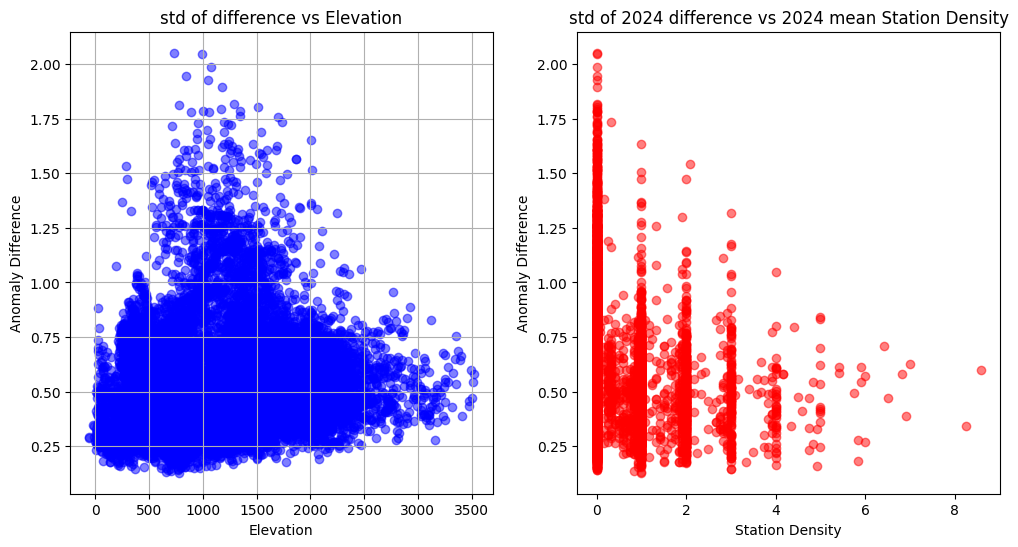

In [11]:
# create scatter plots of wus_difference vs. wus_elevation and wus_station_density vs. wus_difference

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(wus_elevation.elevation, wus_diff_std, c='blue', alpha=0.5)
plt.xlabel('Elevation')
plt.ylabel('Anomaly Difference')
plt.title('std of difference vs Elevation')
plt.grid() 
plt.subplot(1, 2, 2)
plt.scatter(wus_station_mean, wus_diff_std, c='red', alpha=0.5)
plt.xlabel('Station Density')
plt.ylabel('Anomaly Difference')
plt.title('std of 2024 difference vs 2024 mean Station Density')